In [1]:
# --- Connexion à Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Installation des packages manquants ---
!pip install git+https://github.com/MDCHAMP/hawk-data          # API Hawk
!pip install --upgrade scipy                                   # SciPy à jour
!pip install pywavelets scikit-image                           # CWT & resize

Mounted at /content/drive
  Cloning https://github.com/MDCHAMP/hawk-data to /tmp/pip-req-build-h3pqph67
  Running command git clone --filter=blob:none --quiet https://github.com/MDCHAMP/hawk-data /tmp/pip-req-build-h3pqph67
  Resolved https://github.com/MDCHAMP/hawk-data to commit 0bdb659fe4514c3a2325afff4d9f3d83d18d5e93
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hawk: filename=hawk-0.0.1-py3-none-any.whl size=13033 sha256=42026556e854a81a0aaac4c31bbd3a68e35d3ec6d32ff418af25c518d7fb74d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-x4jro3md/wheels/6a/91/56/e31f56cbcb680c5dfd4cca16599696248dd1f5321f2e612f98
Successfully built hawk


In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pywt
from skimage.transform import resize
from hawk import FST
from sklearn.preprocessing import minmax_scale

# Paramètres d’affichage (Seaborn)
sns.set_theme("notebook")
sns.set_style("ticks")
sns.set_palette("Set2")

In [ ]:
# fonction hawk.FST permettant d’interagir avec les données issues du test sur l’aile tribord.
data_dir = "./hawk_data"
data = FST(data_dir)
data.describe()

'Header file for Hawk dataset.  See documentation for details.'

In [141]:
# 🧾 Liste des tests par classe
tests_par_classe = {
    "HS": [
        "HS_WN/01",
        "HS_WN/02",
        "HS_WN/03",
        "HS_WN/04",
        "HS_WN/05"
    ],
    "DS_CTE": [
        "DS_WN/01",
        "DS_WN/02",
        "DS_WN/03",
        "DS_WN/19",
        "DS_WN/20",
        "DS_WN/21",
        "DS_WN/64",
        "DS_WN/65",
        "DS_WN/66"
    ],
    "DS_RLE": [
        "DS_WN/04",
        "DS_WN/05",
        "DS_WN/06",
        "DS_WN/22",
        "DS_WN/23",
        "DS_WN/24",
        "DS_WN/67",
        "DS_WN/68",
        "DS_WN/69"
    ],
    "DS_TLE": [
        "DS_WN/07",
        "DS_WN/08",
        "DS_WN/09",
        "DS_WN/25",
        "DS_WN/26",
        "DS_WN/27",
        "DS_WN/70",
        "DS_WN/71",
        "DS_WN/72"
    ]
}

In [89]:
# Dictionnaire pour stocker les résultats
resultats = {}

for classe, tests in tests_par_classe.items():
    for test_path in tests:
        print(f"🔹 Extraction {test_path} ({classe})")
        test_group = data[test_path]
        signaux = []

        for i in range(1, 11):  # 10 capteurs FBG
            capteur = f"SW_FB{i}"
            strain = test_group[capteur]['strain'][:]       # shape = (163840, 10)
            signal_moyen = strain.mean(axis=1)              # moyenne sur répétitions
            signaux.append(signal_moyen)

        signaux_array = np.array(signaux)  # shape = [10, 163840]

        # Sauvegarde en mémoire (ou plus tard en .npy / .png)
        resultats[test_path] = {
            "classe": classe,
            "signaux": signaux_array  # matrice [10, 163840]
        }

        print(f"  → signal shape: {signaux_array.shape}")

🔹 Extraction HS_WN/01 (HS)
  → signal shape: (10, 163840)
🔹 Extraction HS_WN/02 (HS)
  → signal shape: (10, 163840)
🔹 Extraction HS_WN/03 (HS)
  → signal shape: (10, 163840)
🔹 Extraction HS_WN/04 (HS)
  → signal shape: (10, 163840)
🔹 Extraction HS_WN/05 (HS)
  → signal shape: (10, 163840)
🔹 Extraction DS_WN/01 (DS_CTE)
  → signal shape: (10, 163840)
🔹 Extraction DS_WN/02 (DS_CTE)
  → signal shape: (10, 163840)
🔹 Extraction DS_WN/03 (DS_CTE)
  → signal shape: (10, 163840)
🔹 Extraction DS_WN/19 (DS_CTE)
  → signal shape: (10, 163840)
🔹 Extraction DS_WN/20 (DS_CTE)
  → signal shape: (10, 163840)
🔹 Extraction DS_WN/21 (DS_CTE)
  → signal shape: (10, 163840)
🔹 Extraction DS_WN/64 (DS_CTE)
  → signal shape: (10, 163840)
🔹 Extraction DS_WN/65 (DS_CTE)
  → signal shape: (10, 163840)
🔹 Extraction DS_WN/66 (DS_CTE)
  → signal shape: (10, 163840)
🔹 Extraction DS_WN/04 (DS_RLE)
  → signal shape: (10, 163840)
🔹 Extraction DS_WN/05 (DS_RLE)
  → signal shape: (10, 163840)
🔹 Extraction DS_WN/06 (DS_RL

In [142]:
# Créer une fonction de scalogramme CWT
import pywt
from skimage.transform import resize
from sklearn.preprocessing import minmax_scale
import numpy as np

def compute_scalogram(signal, wavelet='morl', scales=np.arange(1, 65), target_size=(224,)):
    """
    Génère un vecteur (ligne) de scalogramme réduit à 224 colonnes.

    Args:
        signal (1D array): signal de 2048 points
        wavelet (str): ondelette à utiliser (ex: 'morl')
        scales (array): échelles utilisées
        target_size (tuple): largeur finale (temps interpolé)

    Returns:
        vector_1d: np.ndarray [224]
    """
    coefs, _ = pywt.cwt(signal, scales, wavelet)
    scalogram = np.abs(coefs)        # [n_scales x time]
    mean_energy = scalogram.mean(axis=0)  # Moyenne sur les fréquences → 1D

    # Normalisation et redimensionnement
    mean_energy = minmax_scale(mean_energy)
    mean_energy_resized = resize(mean_energy, target_size, mode='reflect', preserve_range=True)

    return mean_energy_resized  # [224]


In [143]:
# Générer les images [10 x 224] pour chaque segment

def generate_cwt_image(signal_array, sample_rate=2048, target_width=224):
    """
    Génère une liste d’images [10x224] à partir d’un signal [10, 163840]

    Args:
        signal_array : np.ndarray [10, 163840]
        sample_rate : nb de points par seconde
        target_width : nb de colonnes interpolées

    Returns:
        List[np.ndarray] : liste de 72 images [10 x 224]
    """
    total_points = signal_array.shape[1]
    margin = int(0.05 * total_points)
    useful_signal = signal_array[:, margin : total_points - margin]  # [10, ~147456]

    win_size = sample_rate
    num_segments = useful_signal.shape[1] // win_size

    images = []
    for k in range(num_segments):
        segment = useful_signal[:, k * win_size : (k + 1) * win_size]  # [10, 2048]

        image = []
        for i in range(10):
            scalogram_line = compute_scalogram(segment[i], target_size=(target_width,))
            image.append(scalogram_line)

        image_array = np.array(image)  # [10, 224]
        images.append(image_array)

    return images


In [144]:
# Sauvegarder les images au format PNG

import os
from skimage.io import imsave

def save_images(images, output_dir, test_name, classe):
    """
    Sauvegarde chaque image [10x224] dans un dossier donné.

    Args:
        images : liste de tableaux [10x224]
        output_dir : dossier racine
        test_name : nom du test (ex: HS_WN_01)
        classe : nom de la classe (ex: HS)
    """
    class_dir = os.path.join(output_dir, classe)
    os.makedirs(class_dir, exist_ok=True)

    for i, img in enumerate(images):
        img_uint8 = np.clip(img * 255, 0, 255).astype(np.uint8)
        filename = f"{test_name.replace('/', '_')}_{i:02d}.png"
        path = os.path.join(class_dir, filename)
        imsave(path, img_uint8)


In [145]:
# Boucle sur les tests et génération des

output_dir = "images_cwt"
os.makedirs(output_dir, exist_ok=True)

for classe, chemin in tests:
    try:
        signal_test = resultats[chemin]["signaux"]
    except KeyError:
        print(f"⚠️ Données manquantes pour : {chemin}")
        continue

    images = generate_cwt_image(signal_test)
    save_images(images, output_dir, chemin, classe)
    print(f"✅ {len(images)} images sauvegardées pour {chemin}")


✅ 72 images sauvegardées pour HS_WN/01
✅ 72 images sauvegardées pour HS_WN/02
✅ 72 images sauvegardées pour HS_WN/03
✅ 72 images sauvegardées pour HS_WN/04
✅ 72 images sauvegardées pour HS_WN/05
✅ 72 images sauvegardées pour DS_WN/01
✅ 72 images sauvegardées pour DS_WN/02
✅ 72 images sauvegardées pour DS_WN/03
✅ 72 images sauvegardées pour DS_WN/19
✅ 72 images sauvegardées pour DS_WN/20
✅ 72 images sauvegardées pour DS_WN/21
✅ 72 images sauvegardées pour DS_WN/64
✅ 72 images sauvegardées pour DS_WN/65
✅ 72 images sauvegardées pour DS_WN/66
✅ 72 images sauvegardées pour DS_WN/04
✅ 72 images sauvegardées pour DS_WN/05
✅ 72 images sauvegardées pour DS_WN/06
✅ 72 images sauvegardées pour DS_WN/22
✅ 72 images sauvegardées pour DS_WN/23
✅ 72 images sauvegardées pour DS_WN/24
✅ 72 images sauvegardées pour DS_WN/67
✅ 72 images sauvegardées pour DS_WN/68
✅ 72 images sauvegardées pour DS_WN/69
✅ 72 images sauvegardées pour DS_WN/07
✅ 72 images sauvegardées pour DS_WN/08
✅ 72 images sauvegardées 

In [147]:
import matplotlib.pyplot as plt

def afficher_cwt(images_cwt, titre="Image CWT"):
    """
    Affiche une image CWT [10 × 224] (brute, non redimensionnée)
    """
    plt.figure(figsize=(10, 3))
    plt.imshow(images_cwt, aspect='auto', cmap='gray')
    plt.title(titre)
    plt.xlabel("Temps (échantillons interpolés)")
    plt.ylabel("Capteurs")
    plt.colorbar(label="Amplitude normalisée")
    plt.tight_layout()
    plt.show()


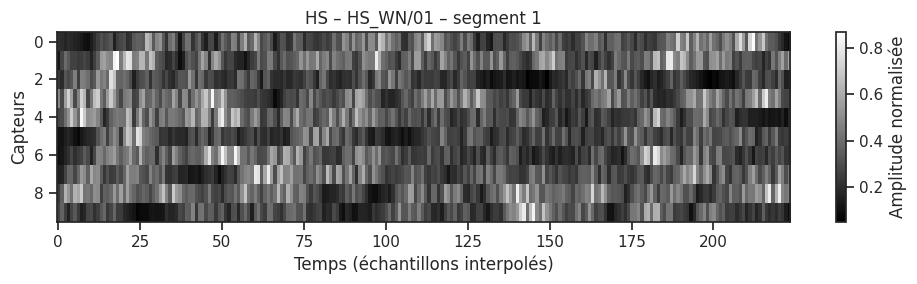

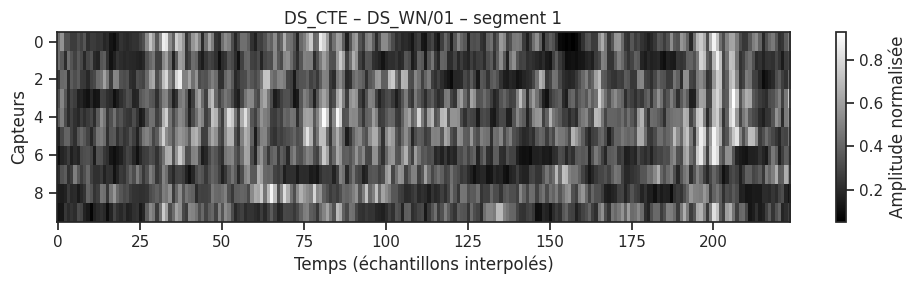

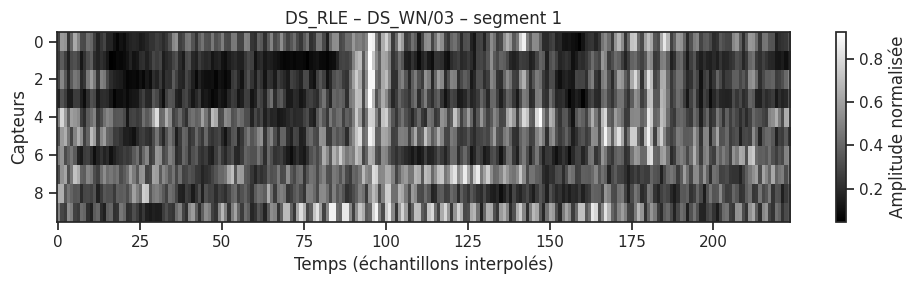

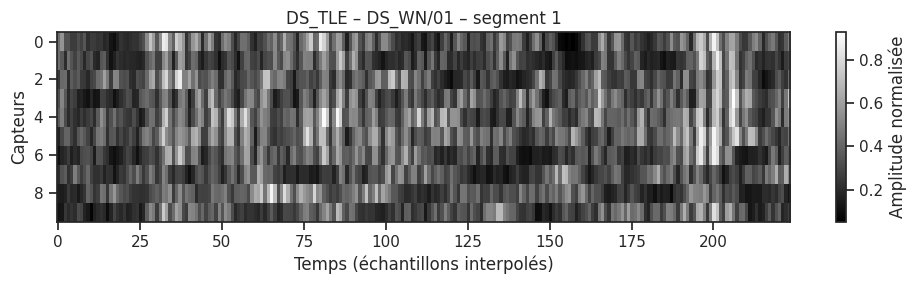

In [148]:
# Sélection d’un exemple de test par classe
exemples = {
    "HS":      "HS_WN/01",
    "DS_CTE":  "DS_WN/01",
    "DS_RLE":  "DS_WN/03",
    "DS_TLE":  "DS_WN/01"
}

# Affichage d'une SDI (la 1re) pour chaque classe
for classe, chemin in exemples.items():
    signal_test = resultats[chemin]["signaux"]  # [10, 163840]

    # Génère les 72 images SDI [10 × 224]
    sdi_list = generate_cwt_image(signal_test)

    # Affiche la première image de la liste
    afficher_cwt(sdi_list[0], titre=f"{classe} – {chemin} – segment 1")

In [149]:
import matplotlib.pyplot as plt

def afficher_sdi_colonne(images, titre_base=""):
    """
    Affiche 3 images SDI [10 × 224] empilées verticalement
    """
    fig, axes = plt.subplots(3, 1, figsize=(8, 6))

    for i, ax in enumerate(axes):
        ax.imshow(images[i], aspect='auto', cmap='gray')
        ax.set_title(f"{titre_base} – segment {i+1}")
        ax.set_xlabel("Temps")
        ax.set_ylabel("Capteurs")

    plt.tight_layout()
    plt.show()


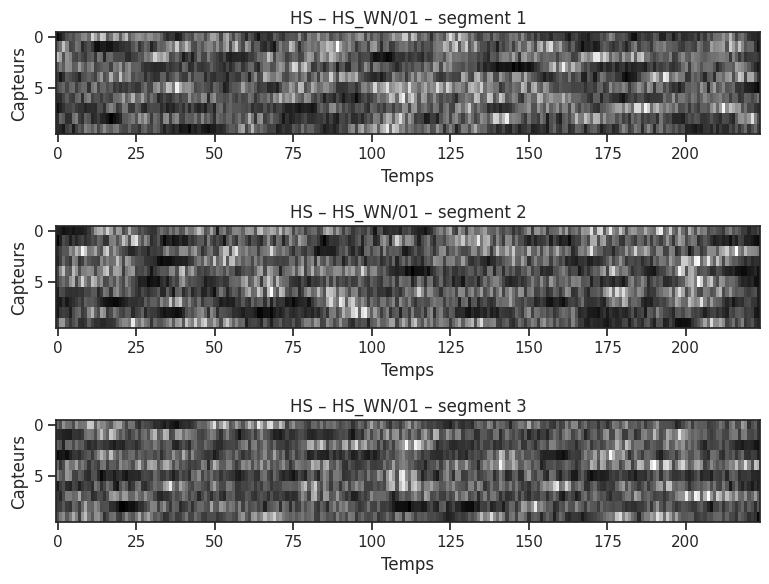

In [150]:
# Test sélectionné
chemin = "HS_WN/01"
classe = "HS"

# Chargement du signal [10 × 163840]
signal_test = resultats[chemin]["signaux"]

# Génère les 72 SDI [10 × 224]
sdi_list = generate_cwt_image(signal_test)

# Sélectionne 3 images consécutives (ex : segment 10 à 12)
start_seg = 10
images = sdi_list[start_seg : start_seg + 3]

# Affiche les 3 images l'une au-dessus de l'autre
afficher_sdi_colonne(images, titre_base=f"{classe} – {chemin}")


In [151]:
import shutil

# Chemin vers ton dossier Drive (ajuste si besoin)
drive_path = "/content/drive/MyDrive/Projet_SDI/images_cwt"

# Copie le dossier local vers ton Drive
shutil.copytree("images_sdi", drive_path, dirs_exist_ok=True)

print(f"Dossier copié vers : {drive_path}")

Dossier copié vers : /content/drive/MyDrive/Projet_SDI/images_cwt


In [17]:
import os

# Dossier contenant les images
image_root = "/content/drive/MyDrive/Projet_SDI/images_sdi"  # ou "/content/images_cwt" si sur Drive

# Initialisation
total_images = 0
par_classe = {}

# Comptage
for classe in os.listdir(image_root):
    classe_path = os.path.join(image_root, classe)
    if os.path.isdir(classe_path):
        nb_images = len([f for f in os.listdir(classe_path) if f.endswith(".png")])
        par_classe[classe] = nb_images
        total_images += nb_images

# Affichage
print("📦 Nombre d’images par classe :")
for classe, count in par_classe.items():
    print(f"  ➤ {classe} : {count} images")

print(f"\n✅ Total général : {total_images} images")


📦 Nombre d’images par classe :
  ➤ DS_RLE : 648 images
  ➤ DS_TLE : 648 images
  ➤ HS : 360 images
  ➤ DS_CTE : 648 images

✅ Total général : 2304 images


In [18]:
import os
from PIL import Image
import numpy as np

# Dossier à vérifier
base_dir = "/content/drive/MyDrive/Projet_SDI/images_cwt"

# Résultats
erreurs = []

# Boucle sur chaque sous-dossier (HS, DS_CTE, etc.)
for classe in os.listdir(base_dir):
    classe_path = os.path.join(base_dir, classe)
    if not os.path.isdir(classe_path): continue

    for filename in os.listdir(classe_path):
        if filename.endswith(".png"):
            file_path = os.path.join(classe_path, filename)
            try:
                img = Image.open(file_path)
                img_array = np.array(img)

                if img_array.shape[:2] != (10, 224):
                    erreurs.append((filename, img_array.shape))
            except Exception as e:
                erreurs.append((filename, f"Erreur : {e}"))

# Résumé
if erreurs:
    print(f"❌ {len(erreurs)} images ont des dimensions incorrectes :")
    for nom, shape in erreurs[:10]:  # Affiche les 10 premières erreurs
        print(f"  ➤ {nom} → {shape}")
    if len(erreurs) > 10:
        print(f"  ... ({len(erreurs) - 10} autres erreurs non affichées)")
else:
    print("✅ Toutes les images dans images_sdi/ sont bien de taille [10, 224].")


✅ Toutes les images dans images_sdi/ sont bien de taille [10, 224].


In [54]:
# effacer un dossier

import shutil
import os

dossier_a_supprimer = "/content/images_cwt_224x224_rgb"

if os.path.exists(dossier_a_supprimer):
    shutil.rmtree(dossier_a_supprimer)
    print(f"✅ Dossier supprimé : {dossier_a_supprimer}")
else:
    print(f"❌ Dossier introuvable : {dossier_a_supprimer}")


❌ Dossier introuvable : /content/images_cwt_224x224_rgb


In [55]:
import os
import numpy as np
from skimage.io import imread, imsave

# === Resize vertical par répétition pour transformer [10, 224] → [224, 224] ===
def resize_vertical_all_repeat(images_cwt, target_height=224):
    current_height, width = images_cwt.shape
    reps = target_height // current_height
    extra = target_height % current_height
    repeated = np.repeat(images_cwt, reps, axis=0)
    if extra > 0:
        padding = images_cwt[:extra, :]
        repeated = np.vstack([repeated, padding])
    if repeated.shape != (224, 224):
        print(f"⚠️ ATTENTION: taille finale incorrecte : {repeated.shape}")
    return repeated

# === Dossiers ===
input_dir = "images_cwt"
output_dir = "images_cwt_224x224_rgb"
os.makedirs(output_dir, exist_ok=True)

# === Traitement par classe ===
for classe in os.listdir(input_dir):
    input_classe_dir = os.path.join(input_dir, classe)
    output_classe_dir = os.path.join(output_dir, classe)
    os.makedirs(output_classe_dir, exist_ok=True)

    for filename in os.listdir(input_classe_dir):
        if not filename.endswith(".png"): continue

        image_path = os.path.join(input_classe_dir, filename)
        image = imread(image_path)

        # Resize selon type d’image
        if image.ndim == 2:  # Grayscale [10, 224]
            if image.shape != (10, 224):
                print(f"⚠️ Mauvaise taille ignorée : {filename} → {image.shape}")
                continue
            image_resized = resize_vertical_all_repeat(image)

        elif image.ndim == 3:  # Couleur [10, 224, C]
            if image.shape[0] != 10 or image.shape[1] != 224:
                print(f"⚠️ Mauvaise taille ignorée : {filename} → {image.shape}")
                continue

            # Enlever canal alpha si présent (RGBA)
            if image.shape[2] == 4:
                image = image[:, :, :3]

            image_resized = np.stack([
                resize_vertical_all_repeat(image[..., c])
                for c in range(image.shape[2])
            ], axis=-1)

        else:
            print(f"⚠️ Format inattendu ignoré : {filename}")
            continue

        # 🔁 Conversion en 3 canaux RGB si image est en niveaux de gris
        if image_resized.ndim == 2:
            image_resized = np.stack([image_resized] * 3, axis=-1)  # [224, 224, 3]

        # Conversion en uint8 si nécessaire
        if image_resized.dtype != np.uint8:
            image_resized = np.clip(image_resized, 0, 1) * 255
            image_resized = image_resized.astype(np.uint8)

        # Sauvegarde
        output_path = os.path.join(output_classe_dir, filename)
        imsave(output_path, image_resized)

print("✅ Toutes les images ont été redimensionnées et converties en RGB (3 canaux) dans : images_cwt_224x224_rgb/")


FileNotFoundError: [Errno 2] No such file or directory: 'images_cwt'

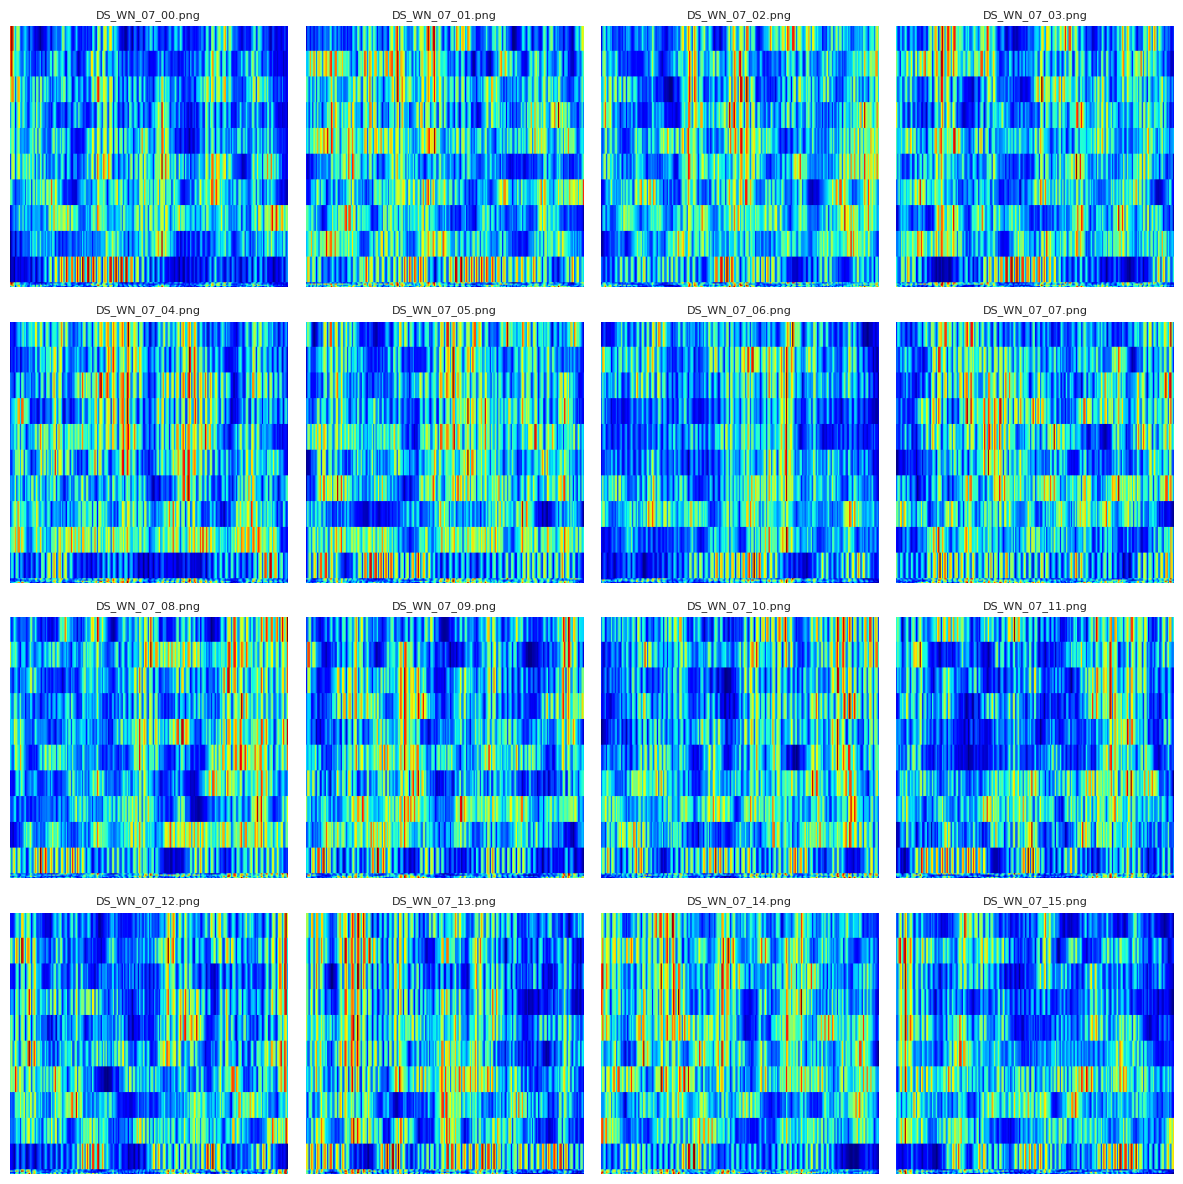

In [5]:
import os
import matplotlib.pyplot as plt
from skimage.io import imread

# === Paramètres ===
base_dir = "/content/drive/MyDrive/Projet_SDI/images_cwt_224x224_rgb"
classe = "DS_TLE"  # changer par "DS_CTE", "DS_RLE", "DS_TLE" si besoin
nb_images = 16  # nombre d’images à afficher
rows, cols = 4, 4  # disposition en grille

# === Récupération des chemins d’images ===
classe_dir = os.path.join(base_dir, classe)
all_files = [f for f in os.listdir(classe_dir) if f.endswith(".png")]
all_files.sort()  # optionnel : pour ordre reproductible
selected_files = all_files[:nb_images]

# === Affichage ===
plt.figure(figsize=(cols * 3, rows * 3))

for i, filename in enumerate(selected_files):
    image_path = os.path.join(classe_dir, filename)
    image = imread(image_path)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(image, cmap='jet', aspect='auto')
    plt.title(filename, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [169]:
import shutil

# Chemin vers ton dossier Drive (ajuste si besoin)
drive_path = "/content/drive/MyDrive/Projet_SDI/images_cwt_224x224_rgb"

# Copie le dossier local vers ton Drive
shutil.copytree("images_cwt_224x224", drive_path, dirs_exist_ok=True)

print(f"Dossier copié vers : {drive_path}")

Dossier copié vers : /content/drive/MyDrive/Projet_SDI/images_cwt_224x224_rgb


In [20]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class CWTImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Dossier racine contenant les sous-dossiers par classe
            transform (callable, optional): Transformations à appliquer sur les images
        """
        self.root_dir = root_dir
        self.transform = transform

        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # Lecture des sous-dossiers (classes)
        classes = sorted(os.listdir(root_dir))
        for idx, class_name in enumerate(classes):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            self.class_to_idx[class_name] = idx

            for fname in os.listdir(class_path):
                if fname.endswith(".png"):
                    self.image_paths.append(os.path.join(class_path, fname))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Charger image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # ⚠️ convertit explicitement en 3 canaux

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


In [21]:
import timm
import torch.nn as nn

def get_swin_tiny_partial_finetune(num_classes=4, pretrained=True, unfreeze_stages=(3,)):
    """
    Charge Swin Transformer-Tiny avec fine-tuning partiel (défiger certains stages).

    Args:
        num_classes (int): nombre de classes en sortie
        pretrained (bool): utiliser les poids ImageNet
        unfreeze_stages (tuple): indices des stages à défiger (0 à 3 pour Swin)

    Returns:
        torch.nn.Module: modèle prêt pour l'entraînement partiel
    """
    model = timm.create_model(
        'swin_tiny_patch4_window7_224',
        pretrained=pretrained,
        num_classes=num_classes
    )

    # Geler tous les paramètres d'abord
    for param in model.parameters():
        param.requires_grad = False

    # Défiger les stages spécifiés (par défaut stage 3 = dernier)
    for stage_idx in unfreeze_stages:
        stage = getattr(model, f"layers.{stage_idx}", None)
        if stage:
            for param in stage.parameters():
                param.requires_grad = True

    # Toujours entraîner le head
    for param in model.head.parameters():
        param.requires_grad = True

    return model


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_loader, val_loader, device, num_epochs=10, lr=1e-4):
    """
    Entraîne un modèle Swin sur un dataset FBG.

    Args:
        model: modèle PyTorch (ex: Swin)
        train_loader: DataLoader PyTorch (train)
        val_loader: DataLoader PyTorch (val)
        device: "cuda" ou "cpu"
        num_epochs: nombre d’époques
        lr: learning rate

    Returns:
        modèle entraîné
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # === Entraînement ===
        for inputs, labels in tqdm(train_loader, desc=f"[Époque {epoch+1}]"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100. * correct / total
        print(f" Train — Époque {epoch+1} : Loss = {running_loss:.4f} | Acc = {train_acc:.2f}%")

        # === Validation ===
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100. * val_correct / val_total
        print(f"🧪 Validation — Acc = {val_acc:.2f}%")

    return model


In [52]:
# copier les images de google dive vers collab
import shutil

# Chemin source (dans Google Drive)
source_dir = "/content/drive/MyDrive/Projet_SDI/images_cwt_224x224"

# Chemin destination (dans Colab)
destination_dir = "/content/images_cwt_224x224"

# Copie du dossier complet
shutil.copytree(source_dir, destination_dir)


'/content/images_cwt_224x224'

In [24]:
# verification des stst images
import os

# Dossier contenant les images
image_root = "images_cwt_224x224_rgb"

# Initialisation
total_images = 0
par_classe = {}

# Comptage
for classe in os.listdir(image_root):
    classe_path = os.path.join(image_root, classe)
    if os.path.isdir(classe_path):
        nb_images = len([f for f in os.listdir(classe_path) if f.endswith(".png")])
        par_classe[classe] = nb_images
        total_images += nb_images

# Affichage
print(" Nombre d’images par classe :")
for classe, count in par_classe.items():
    print(f"  ➤ {classe} : {count} images")

print(f"\n Total général : {total_images} images")

 Nombre d’images par classe :
  ➤ HS : 360 images
  ➤ DS_RLE : 648 images
  ➤ DS_TLE : 648 images
  ➤ DS_CTE : 648 images

 Total général : 2304 images


In [25]:
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
import torch

# Chargement du dataset complet
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
full_dataset = CWTImageDataset("images_cwt_224x224_rgb", transform=transform)

# Déterminer les tailles
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # pour que la somme soit exacte

# Split aléatoire mais reproductible
generator = torch.Generator().manual_seed(42)
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size], generator=generator)

# Loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

print(f"✅ Split terminé : train = {train_size}, val = {val_size}, test = {test_size}")


✅ Split terminé : train = 1612, val = 345, test = 347


In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import numpy as np

def evaluate_model(model, test_loader, device, class_names=None):
    """
    Évalue un modèle sur un DataLoader de test.

    Args:
        model: modèle entraîné
        test_loader: DataLoader contenant les données de test
        device: "cuda" ou "cpu"
        class_names: liste optionnelle de noms de classes

    Affiche la précision, la matrice de confusion, et le rapport de classification.
    """
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Métriques
    acc = accuracy_score(all_labels, all_preds)
    print(f" Test Accuracy: {acc * 100:.2f}%")

    print("\n Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("\n Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)


In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import timm
import torchvision.transforms as T
from PIL import Image
import cv2

class AttentionRollout:
    def __init__(self, model, discard_ratio=0.9):
        self.model = model
        self.discard_ratio = discard_ratio
        self.attentions = []

        # Ajout des hooks
        for i in range(4):  # layers 0 à 3
            for block in model.layers[i]:
                block.attn.register_forward_hook(self.save_attn)

    def save_attn(self, module, input, output):
        # output = attention scores [B, heads, N, N]
        self.attentions.append(output.detach().cpu())

    def rollout(self):
        # Moyenne sur les heads, puis produit matriciel accumulé
        result = torch.eye(self.attentions[0].size(-1))
        for attn in self.attentions:
            attn_heads = attn.mean(dim=1)  # moyenne des têtes
            attn_heads = attn_heads / attn_heads.sum(dim=-1, keepdim=True)
            result = attn_heads @ result  # propagation
        return result[0, 0, 1:]  # sauf token de classe

    def get_attention_map(self, image_tensor):
        _ = self.model(image_tensor.unsqueeze(0))  # forward
        rollout = self.rollout()
        self.attentions.clear()

        n_patches = rollout.shape[0]
        size = int(n_patches ** 0.5)
        mask = rollout.reshape(size, size).numpy()
        mask = cv2.resize(mask, (224, 224))
        mask = (mask - mask.min()) / (mask.max() - mask.min())
        return mask


In [49]:
import os
from PIL import Image, UnidentifiedImageError

def supprimer_images_corrompues(dossier_racine):
    nb_total = 0
    nb_supprimees = 0

    for root, _, files in os.walk(dossier_racine):
        for nom_fichier in files:
            chemin_fichier = os.path.join(root, nom_fichier)
            nb_total += 1
            try:
                with Image.open(chemin_fichier) as img:
                    img.verify()  # Vérifie que l’image est valide
            except (UnidentifiedImageError, OSError):
                os.remove(chemin_fichier)
                nb_supprimees += 1
                print(f"🗑️ Supprimée : {chemin_fichier}")

    print(f"\n✅ Nettoyage terminé : {nb_supprimees}/{nb_total} image(s) corrompue(s) supprimée(s).")

# Exemple d'utilisation
dossier_images = "images_cwt_224x224_rgb"  # change si besoin
supprimer_images_corrompues(dossier_images)



✅ Nettoyage terminé : 0/2303 image(s) corrompue(s) supprimée(s).


In [39]:
# Déplacer le modèle sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Device utilisé : {device}")

# Charger le modèle Swin partiellement fine-tuné
model = get_swin_tiny_partial_finetune()
model.to(device)

# Critère de perte et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Lancement de l'entraînement (sans noms d'arguments)
model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=25,
    lr=1e-4
)


🖥️ Device utilisé : cuda


[Époque 1]: 100%|██████████| 51/51 [00:03<00:00, 14.56it/s]


 Train — Époque 1 : Loss = 67.7483 | Acc = 27.11%
🧪 Validation — Acc = 36.81%


[Époque 2]: 100%|██████████| 51/51 [00:03<00:00, 14.77it/s]


 Train — Époque 2 : Loss = 64.5413 | Acc = 37.47%
🧪 Validation — Acc = 37.97%


[Époque 3]: 100%|██████████| 51/51 [00:03<00:00, 14.61it/s]


 Train — Époque 3 : Loss = 62.1390 | Acc = 36.23%
🧪 Validation — Acc = 37.10%


[Époque 4]: 100%|██████████| 51/51 [00:03<00:00, 14.67it/s]


 Train — Époque 4 : Loss = 60.1940 | Acc = 37.84%
🧪 Validation — Acc = 38.55%


[Époque 5]: 100%|██████████| 51/51 [00:03<00:00, 14.82it/s]


 Train — Époque 5 : Loss = 58.8890 | Acc = 38.96%
🧪 Validation — Acc = 37.10%


[Époque 6]: 100%|██████████| 51/51 [00:03<00:00, 14.49it/s]


 Train — Époque 6 : Loss = 57.6288 | Acc = 39.95%
🧪 Validation — Acc = 39.71%


[Époque 7]: 100%|██████████| 51/51 [00:03<00:00, 14.71it/s]


 Train — Époque 7 : Loss = 56.6319 | Acc = 40.88%
🧪 Validation — Acc = 39.42%


[Époque 8]: 100%|██████████| 51/51 [00:03<00:00, 14.68it/s]


 Train — Époque 8 : Loss = 56.1263 | Acc = 41.50%
🧪 Validation — Acc = 41.16%


[Époque 9]: 100%|██████████| 51/51 [00:03<00:00, 14.26it/s]


 Train — Époque 9 : Loss = 55.6877 | Acc = 39.58%
🧪 Validation — Acc = 42.32%


[Époque 10]: 100%|██████████| 51/51 [00:03<00:00, 14.69it/s]


 Train — Époque 10 : Loss = 54.9801 | Acc = 41.75%
🧪 Validation — Acc = 40.58%


[Époque 11]: 100%|██████████| 51/51 [00:03<00:00, 14.65it/s]


 Train — Époque 11 : Loss = 54.6126 | Acc = 42.74%
🧪 Validation — Acc = 40.58%


[Époque 12]: 100%|██████████| 51/51 [00:03<00:00, 14.49it/s]


 Train — Époque 12 : Loss = 54.5951 | Acc = 42.62%
🧪 Validation — Acc = 42.32%


[Époque 13]: 100%|██████████| 51/51 [00:03<00:00, 14.67it/s]


 Train — Époque 13 : Loss = 54.0268 | Acc = 42.37%
🧪 Validation — Acc = 42.90%


[Époque 14]: 100%|██████████| 51/51 [00:03<00:00, 14.78it/s]


 Train — Époque 14 : Loss = 53.4611 | Acc = 42.87%
🧪 Validation — Acc = 44.06%


[Époque 15]: 100%|██████████| 51/51 [00:03<00:00, 14.75it/s]


 Train — Époque 15 : Loss = 53.1862 | Acc = 45.66%
🧪 Validation — Acc = 45.80%


[Époque 16]: 100%|██████████| 51/51 [00:03<00:00, 14.85it/s]


 Train — Époque 16 : Loss = 52.6953 | Acc = 47.52%
🧪 Validation — Acc = 45.51%


[Époque 17]: 100%|██████████| 51/51 [00:03<00:00, 14.89it/s]


 Train — Époque 17 : Loss = 52.6248 | Acc = 46.28%
🧪 Validation — Acc = 46.38%


[Époque 18]: 100%|██████████| 51/51 [00:03<00:00, 14.59it/s]


 Train — Époque 18 : Loss = 52.6322 | Acc = 45.60%
🧪 Validation — Acc = 42.03%


[Époque 19]: 100%|██████████| 51/51 [00:03<00:00, 14.73it/s]


 Train — Époque 19 : Loss = 52.1046 | Acc = 47.70%
🧪 Validation — Acc = 45.51%


[Époque 20]: 100%|██████████| 51/51 [00:03<00:00, 14.74it/s]


 Train — Époque 20 : Loss = 52.3993 | Acc = 48.26%
🧪 Validation — Acc = 43.48%


[Époque 21]: 100%|██████████| 51/51 [00:03<00:00, 14.66it/s]


 Train — Époque 21 : Loss = 51.9291 | Acc = 47.33%
🧪 Validation — Acc = 44.93%


[Époque 22]: 100%|██████████| 51/51 [00:03<00:00, 14.65it/s]


 Train — Époque 22 : Loss = 51.7840 | Acc = 49.13%
🧪 Validation — Acc = 47.83%


[Époque 23]: 100%|██████████| 51/51 [00:03<00:00, 14.69it/s]


 Train — Époque 23 : Loss = 51.6045 | Acc = 46.65%
🧪 Validation — Acc = 49.86%


[Époque 24]: 100%|██████████| 51/51 [00:03<00:00, 14.64it/s]


 Train — Époque 24 : Loss = 51.2650 | Acc = 49.69%
🧪 Validation — Acc = 48.41%


[Époque 25]: 100%|██████████| 51/51 [00:03<00:00, 14.91it/s]


 Train — Époque 25 : Loss = 51.6248 | Acc = 49.19%
🧪 Validation — Acc = 46.67%


In [40]:
class_names = ['DS_CTE', 'DS_RLE', 'DS_TLE', 'HS']  # adapte selon ton encodage exact

In [48]:
evaluate_model(model, test_loader, device, class_names)

FileNotFoundError: [Errno 2] No such file or directory: 'images_cwt_224x224_rgb/DS_CTE/DS_WN_65_18.png'

In [33]:
import torch
import timm
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger le modèle Swin pré-entraîné
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
model.to(device)
model.eval()

# --- 1. Enregistrer les cartes d’attention ---
attention_maps = []

def register_hooks(model):
    for i in range(4):  # 4 stages dans Swin
        for block in model.layers[i]:
            block.attn.register_forward_hook(hook_fn)

def hook_fn(module, input, output):
    attn = output  # [B, heads, N, N]
    attn_mean = attn.mean(1)  # moyenne sur les têtes → [B, N, N]
    attention_maps.append(attn_mean.detach().cpu())

register_hooks(model)

# --- 2. Charger et préparer l’image ---
def load_image(img_path):
    img = Image.open(img_path).convert('RGB')  # tu convertis grayscale en RGB
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485]*3, [0.229]*3)
    ])
    return transform(img).unsqueeze(0).to(device)

# --- 3. Générer les heatmaps par couche ---
def save_attention_heatmaps(img_path, output_dir="attention_layers"):
    os.makedirs(output_dir, exist_ok=True)
    attention_maps.clear()

    image_tensor = load_image(img_path)
    with torch.no_grad():
        _ = model(image_tensor)

    for i, attn in enumerate(attention_maps):
        rollout = attn[0, 0, 1:]  # ligne [CLS] vers tokens image
        num_patches = rollout.shape[0]
        side = int(num_patches ** 0.5)

        heatmap = rollout.reshape(side, side).numpy()
        heatmap = cv2.resize(heatmap, (224, 224))
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

        plt.imsave(f"{output_dir}/layer_{i+1:02d}.png", heatmap, cmap='jet')

    print(f"✅ {len(attention_maps)} cartes sauvegardées dans : {output_dir}/")

# --- 4. Exemple d'utilisation ---
img_path = "images_cwt_224x224_rgb/DS_CTE/DS_WN_01_00.png"
save_attention_heatmaps(img_path)


TypeError: 'SwinTransformerStage' object is not iterable

In [31]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def display_attention_grid(attn_dir="attention_layers", ncols=4):
    # Lister et trier les fichiers attention
    files = sorted([f for f in os.listdir(attn_dir) if f.endswith(".png")])
    n_layers = len(files)
    nrows = (n_layers + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))

    for idx, file in enumerate(files):
        row = idx // ncols
        col = idx % ncols
        ax = axes[row, col] if nrows > 1 else axes[col]
        img = Image.open(os.path.join(attn_dir, file))
        ax.imshow(img)
        ax.set_title(f"Layer {idx+1}")
        ax.axis("off")

    # Si le dernier rangée a des cases vides, on les cache
    for k in range(n_layers, nrows * ncols):
        row = k // ncols
        col = k % ncols
        ax = axes[row, col] if nrows > 1 else axes[col]
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# 🔧 Utilisation :
display_attention_grid("attention_layers", ncols=4)


FileNotFoundError: [Errno 2] No such file or directory: 'attention_layers'